# Basic Feature Engineering

---

Before diving into more complex data types such as text or images, let's start with the simplest type: numeric data. Since numeric data is already in a format that’s easily digestible by mathematical models, it might seem like little work is needed. However, feature engineering remains essential. Effective features not only capture the key characteristics of the data but also align with the assumptions of the model. This often requires transforming the raw numeric data. Mastering these basic techniques is crucial, as they form the foundation of feature engineering across all data types.

The first check for numeric data is to assess whether the **magnitude** of the values is important. Do you need to know the exact magnitude, or is it sufficient to distinguish between positive and negative values? Sometimes, coarse granularity is all that’s necessary. This is especially true for automatically generated counts, such as daily website visits or the number of reviews for a restaurant.

Next, consider the **scale** of the features. What are the smallest and largest values? Do they vary across a wide range or even several orders of magnitude? This is crucial because many models are sensitive to the scale of the input. For instance, in a simple linear function like $3x + 1$, the output scales directly with the input. Methods like k-means clustering, nearest neighbors, and any algorithm relying on Euclidean distance are highly dependent on the scale of the features. In these cases, it’s a good practice to normalize the data, ensuring the model’s output stays within a predictable range.

On the other hand, some models, such as those involving logical functions, aren’t affected by feature scale. Logical functions, like the AND operation, produce binary outputs regardless of the magnitude of the inputs. Similarly, decision trees, which are built from step functions of input features, don’t require normalization. However, one caveat exists: if a numeric feature is an accumulated count that grows over time, it may eventually exceed the range the tree was trained on. In that case, periodic rescaling of inputs might be necessary to maintain model performance.

Another critical aspect to consider is the **distribution** of numeric features. The distribution defines the likelihood of a feature taking on certain values and can impact different models in various ways. For example, linear regression models assume that prediction errors are normally distributed (Gaussian). This assumption typically holds unless the target variable spans several orders of magnitude. In such cases, the Gaussian error assumption may no longer apply, and transforming the target can help normalize the distribution. A common approach is to apply a log transform, which is a type of *power transformation* that brings the distribution closer to Gaussian.

Understanding these key elements—magnitude, scale, and distribution—will help you design features that improve model performance and generalization.


## Dealing with Counts

In the age of Big Data, counts can accumulate rapidly and without limit. With the ability to produce data at high volume and velocity, it’s common to encounter a few extreme values. These outliers can skew analysis if not handled appropriately.

Therefore, it’s important to assess the scale of your data and decide how to represent it. Depending on the context, you might choose to:

- Keep the data as raw numbers.
- Convert them into binary values to indicate presence or absence.
- Group the data into bins with coarser granularity to manage extreme values and simplify the analysis.

This decision can have a significant impact on how well your model performs, especially when dealing with large datasets that may contain outliers or unbalanced distributions.



### Quantization or Binning

Suppose our task is to use collaborative filtering to predict the rating a user might give to a business. The review count could be a valuable input feature, as there's often a strong correlation between a business's popularity and its ratings. But the question arises: should we use the raw review count, or should we process it further?

Raw counts that span several orders of magnitude can be problematic for many models. For instance, in a linear model, a single coefficient would need to account for the full range of values, from very small counts to extremely large ones. This can result in poor model performance. Similarly, in unsupervised learning methods like k-means clustering, which relies on Euclidean distance for similarity, large counts in one feature could dominate the similarity calculation, overshadowing the influence of other features and skewing the results.

One effective solution is to control the scale by quantizing the count values. Quantization groups continuous data into bins, mapping each value to a discrete bin. The bins can be thought of as representing different levels of intensity. By doing this, we eliminate the issues caused by extreme values while preserving the relative importance of the counts.

To quantize data, we first need to decide how wide each bin should be. The two main approaches are fixed-width binning and adaptive binning, each with its own advantages.

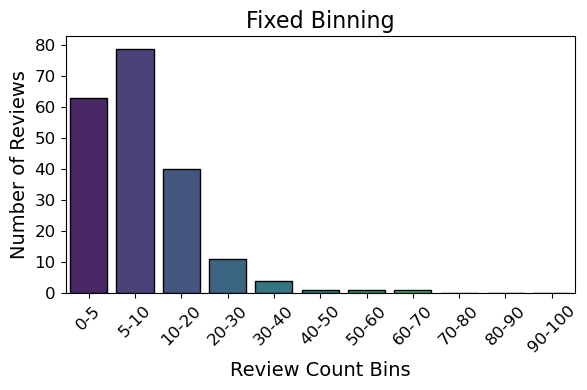

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Generate skewed synthetic review counts using a log-normal distribution
np.random.seed(42)
review_counts = np.random.lognormal(mean=2, sigma=0.8, size=200).astype(int)

# Define fixed bin edges
bin_edges = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Digitize the review counts into bins
binned_counts = np.digitize(review_counts, bins=bin_edges)

# Count occurrences in each bin
binned_data = np.zeros(len(bin_labels), dtype=int)
for i in range(1, len(bin_edges)):
    binned_data[i-1] = np.sum(binned_counts == i)

# Create a DataFrame for plotting
binned_df = pd.DataFrame({'Bin': bin_labels, 'Count': binned_data})

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='Bin', y='Count', data=binned_df, palette='viridis', edgecolor='black')
plt.title('Fixed Binning', fontsize=16)
plt.xlabel('Review Count Bins', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


#### Fixed-Width Binning
With fixed-width binning, each bin represents a specific numeric range. These ranges can either be custom-designed or automatically segmented, depending on the data and the modeling needs. The bins can be linearly scaled (equal-sized intervals) or exponentially scaled (wider bins for larger values).

While fixed-width binning is simple to compute, it may not always be optimal. If the data contains large gaps or unevenly distributed counts, many bins could end up empty, making this approach less effective.

#### Quantile Binning
To address the issue of uneven data distribution, we can use an adaptive technique: quantile binning. Quantile binning positions bins based on the distribution of the data, ensuring that each bin contains roughly the same number of data points. This prevents empty bins and maintains a balanced representation of the data.

Quantiles divide the data into equal portions. For example, the median splits the data into two halves, while quartiles divide it into quarters, and deciles divide it into tenths.



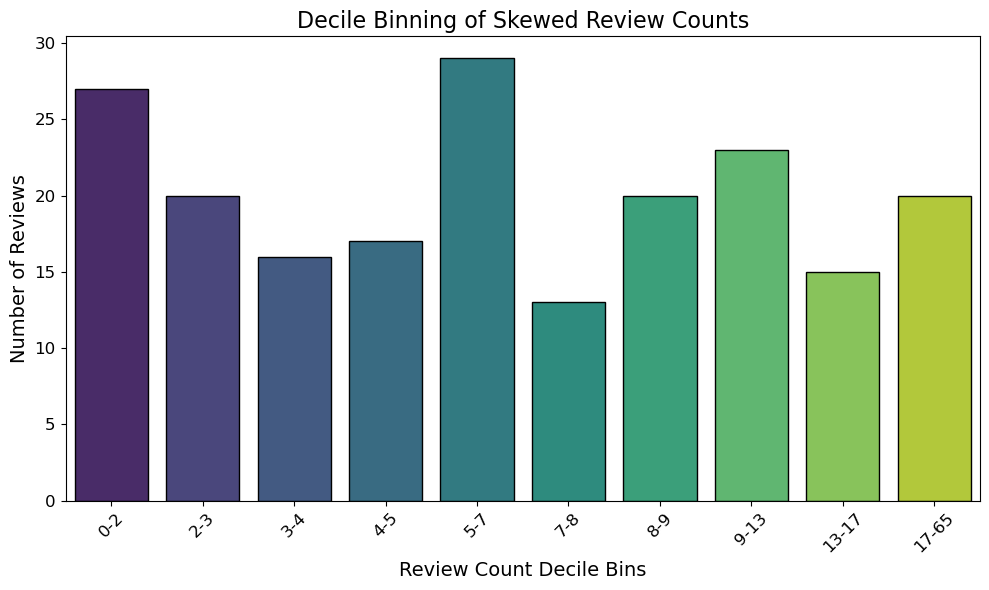

In [2]:
# Define deciles for binning
deciles = np.percentile(review_counts, np.arange(0, 101, 10))
bin_labels = [f"{int(deciles[i])}-{int(deciles[i+1])}" for i in range(len(deciles)-1)]

# Digitize the review counts into decile bins
binned_counts = pd.cut(review_counts, bins=deciles, labels=bin_labels, include_lowest=True)

# Count occurrences in each decile bin
binned_data = binned_counts.value_counts().sort_index()

# Create a DataFrame for plotting
binned_df = pd.DataFrame({'Bin': binned_data.index, 'Count': binned_data.values})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Bin', y='Count', data=binned_df, palette='viridis', edgecolor='black')
plt.title('Decile Binning of Skewed Review Counts', fontsize=16)
plt.xlabel('Review Count Decile Bins', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


### Log Transformation

Another powerful technique for handling large ranges in counts is the logarithmic transform. The log function compresses the range of large numbers and expands smaller ones. As values grow larger, the rate of increase of their logarithm slows down, making it a useful way to tame extreme values. This can be particularly effective when raw counts span several orders of magnitude, as the log transform creates a more manageable range for the model to work with.


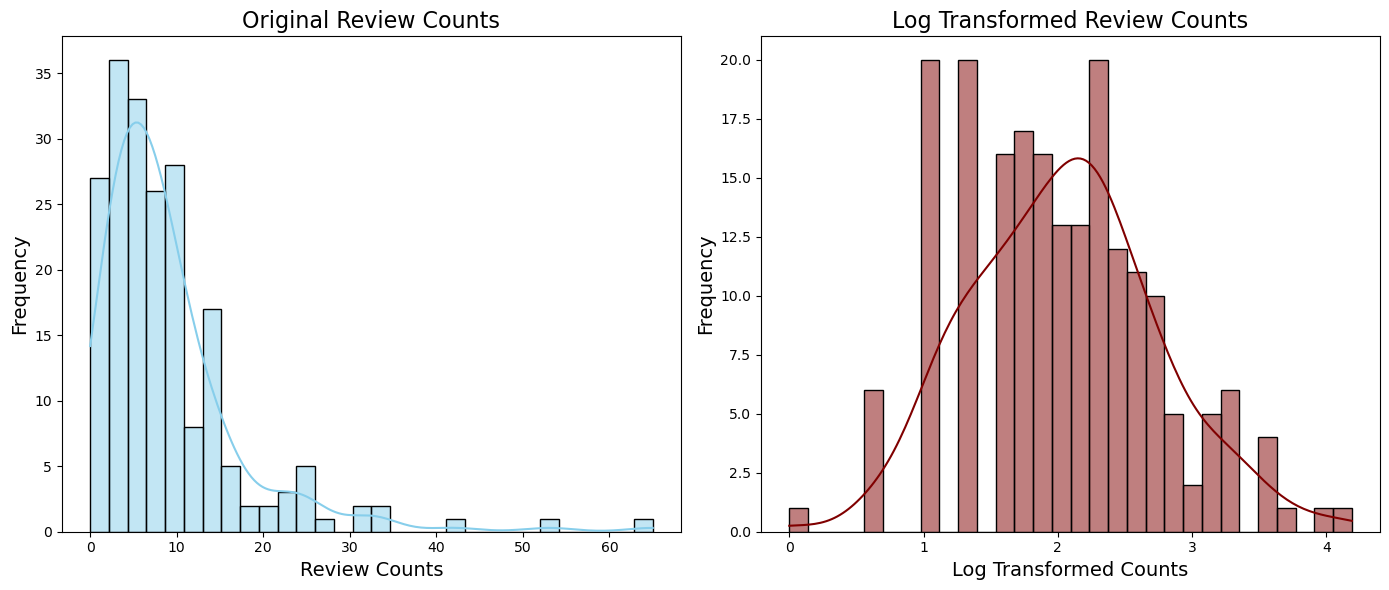

In [3]:
# Apply log transformation (adding 1 to avoid log(0))
log_transformed_counts = np.log1p(review_counts)

# Create DataFrames for original and log-transformed data
original_df = pd.DataFrame({'Review Counts': review_counts})
log_df = pd.DataFrame({'Log Transformed Counts': log_transformed_counts})

# Plotting the original and log-transformed data side by side
plt.figure(figsize=(14, 6))

# Original Data Plot
plt.subplot(1, 2, 1)
sns.histplot(original_df['Review Counts'], bins=30, color='skyblue', kde=True)
plt.title('Original Review Counts', fontsize=16)
plt.xlabel('Review Counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Log Transformed Data Plot
plt.subplot(1, 2, 2)
sns.histplot(log_df['Log Transformed Counts'], bins=30, color='maroon', kde=True)
plt.title('Log Transformed Review Counts', fontsize=16)
plt.xlabel('Log Transformed Counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


 Notice that the distribution looks much more Gaussian after log transformation.

By applying these methods—whether it's binning or using a log transform—we can significantly improve the model's ability to handle the variability, ultimately leading to better predictions.


### Power Transforms: Generalization of the Log Transform

The **log transform** is a specific example of a broader family of transformations known as **power transforms**. These transformations are used in statistics to stabilize variance, meaning they adjust the distribution of a variable so that its variance is no longer dependent on its mean.

A key generalization of both the square root and log transforms is the **Box-Cox transform**. The Box-Cox transform is defined as follows:

$$ 
X^{(\lambda)} = \left\{
\begin{array}{l}
\frac{X^{\lambda} - 1}{\lambda} \ \text{for} \ \lambda \neq 0, \\[10pt]
\log(X) \ \text{for} \ \lambda = 0.
\end{array}
\right.
$$

In this equation, $X$ is the original variable, and $\lambda$ is the **power parameter** that controls the shape of the transformation. The formula is constructed so that when $\lambda = 0$, it reduces to the **logarithmic transform**, $\log(X)$. For other values of $\lambda$, it applies a power transformation to the data. The Box-Cox transformation is continuous as $\lambda$ approaches zero and ensures that the transformed values are **monotonic**, meaning the order of data points is preserved after transformation.

Notable power transforms are:

1. **Square Root Transform ($\lambda = 0.5$)**: The square root transform is useful for stabilizing variance when the variable consists of positive counts or values that grow quadratically. It can help reduce right-skewness in data.
   
2. **Log Transform ($\lambda = 0$)**: /aThe log transform is commonly applied to data with exponential growth or values that span several orders of magnitude. It compresses large values and stretches small ones, making the data easier to model.

3. **Inverse Transform ($\lambda = -1$)**: The inverse transform is sometimes used when larger values of a variable are less significant than smaller values, effectively giving more weight to smaller numbers.

The power parameter $\lambda$ is crucial in determining the transformation's behavior. It can be estimated using graphical techniques, which help to visualize how the transformation affects the distribution, allwing to choose a $\lambda$ that minimizes skewness or makes the data more symmetric. Alternatively, it can be estimated more rigorously through the **maximum-likelihood method**, which uses maximum-likelihood estimation to identify the transformation that best fits the data to a normal distribution.

Power transforms, including the Box-Cox transform, are highly useful when working with skewed data or when it's necessary to make a variable's distribution more symmetric and normal-like, which can improve the performance of many statistical models. However, they are not without limitations. For example, the Box-Cox transform only works on strictly positive data, though this can be handled by shifting the data to make all values positive. While simpler power transforms like the log or square root are easy to understand, arbitrary $\lambda$ values in the Box-Cox transform can be harder to interpret, making the transformed data more challenging to work with. Additionally, excessive use of transformations, especially in complex models, may lead to overfitting, causing the model to fit the transformed data too closely and reducing its ability to generalize to new data.


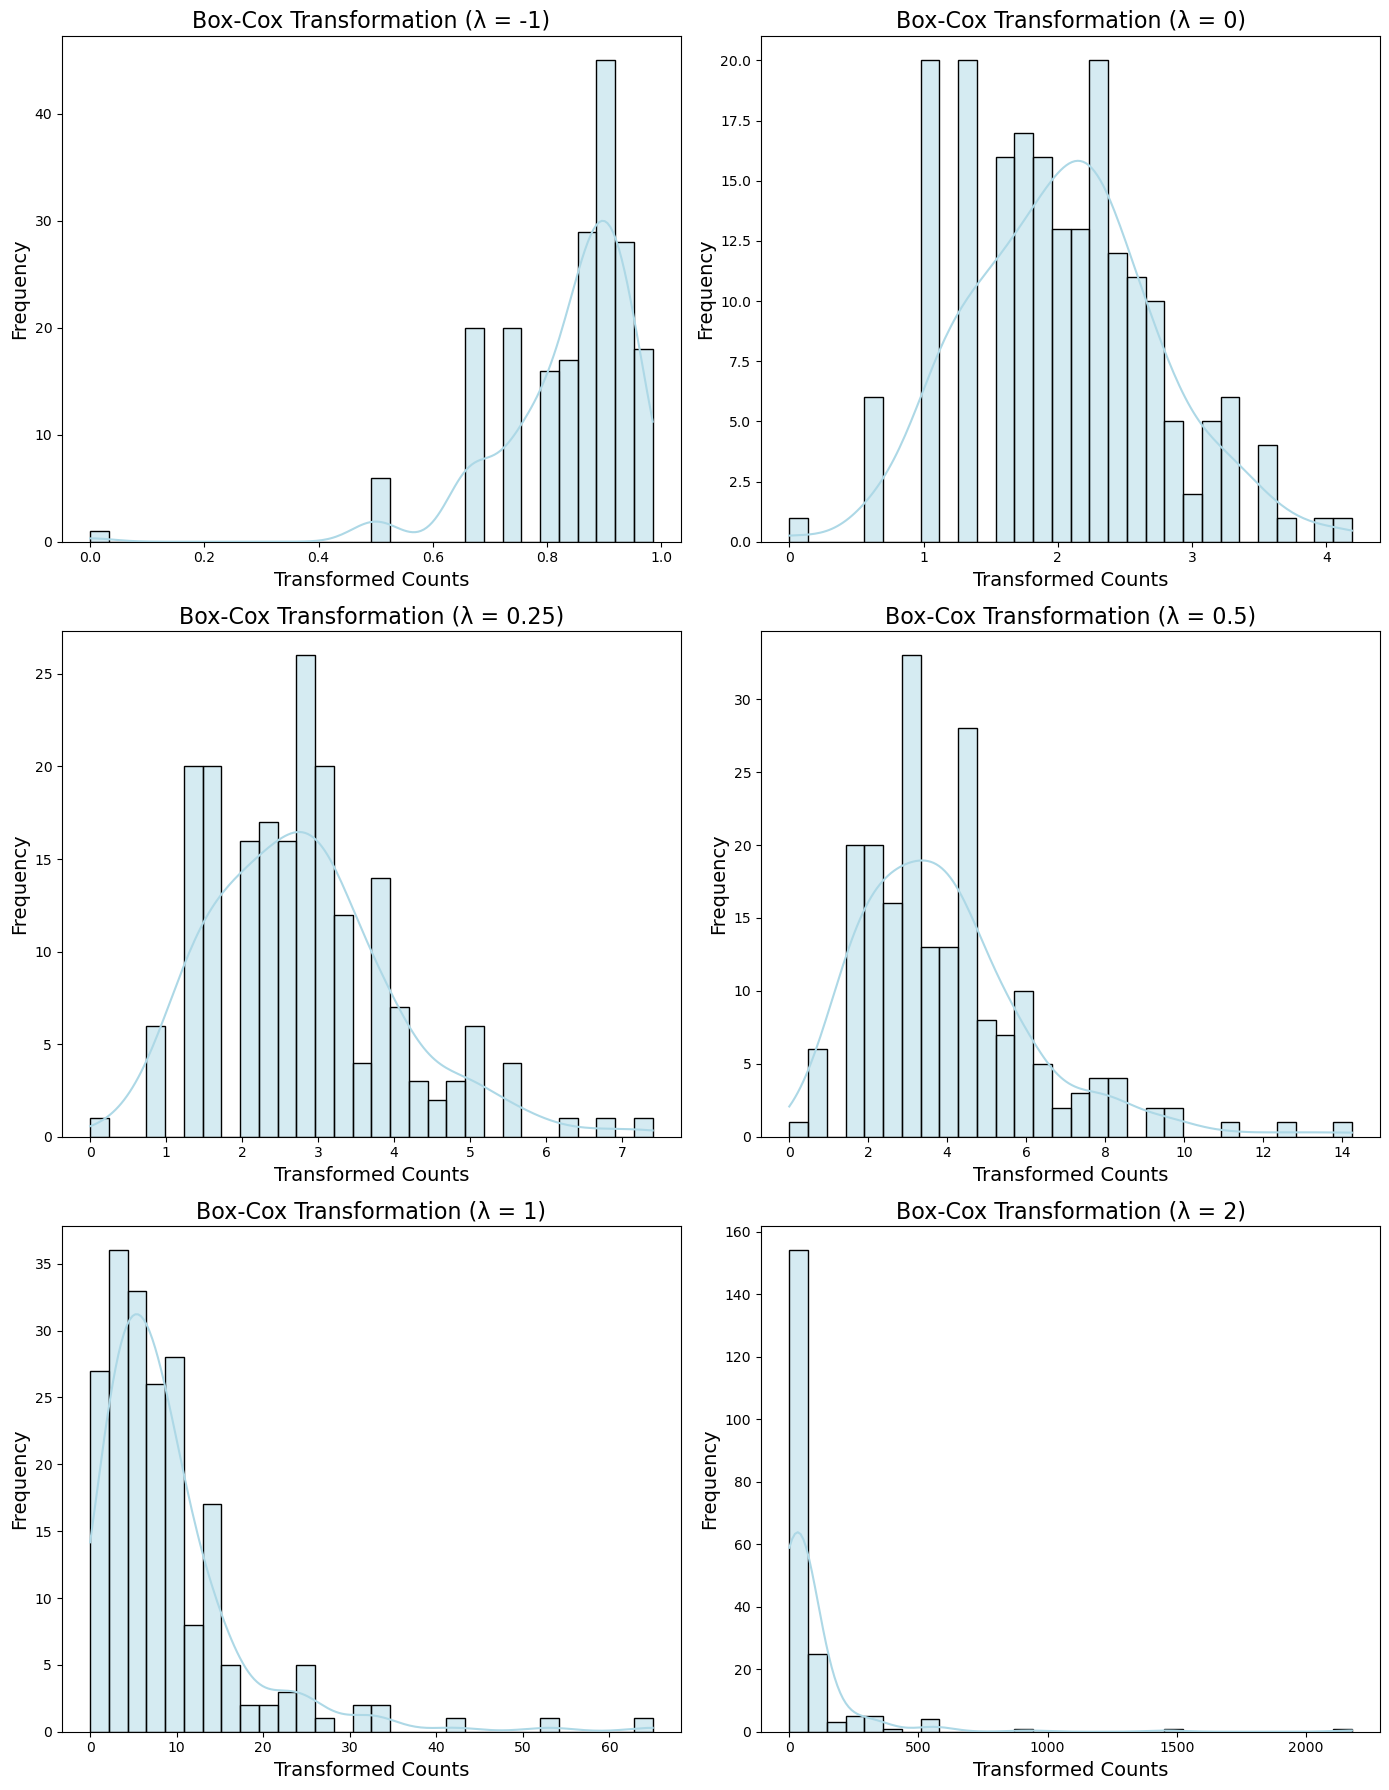

In [13]:
from scipy import stats

# Define lambda values for Box-Cox transformation
lambda_values = [-1, 0, 0.25, 0.5, 1, 2]
transformed_data = []

# Apply Box-Cox transformation for each lambda
for lam in lambda_values:
    if lam == 0:
        # Use log transformation for lambda = 0
        transformed_data.append(np.log1p(review_counts))
    else:
        transformed_data.append(stats.boxcox(review_counts + 1, lmbda=lam))  # Adding 1 to avoid issues with zero values

# Create DataFrame for transformed data
transformed_df = pd.DataFrame(transformed_data).T
transformed_df.columns = [f'Lambda = {lam}' for lam in lambda_values]

# Create a grid for plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Plot transformed data distributions
for i, lam in enumerate(lambda_values):
    ax = axs[i // 2, i % 2]
    sns.histplot(transformed_df[f'Lambda = {lam}'], bins=30, kde=True, color='lightblue', ax=ax)
    ax.set_title(f'Box-Cox Transformation (λ = {lam})', fontsize=16)
    ax.set_xlabel('Transformed Counts', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


## Feature Scaling and Normalization

Feature scaling and normalization are crucial preprocessing steps in machine learning. Many algorithms, especially those based on distances or gradients, perform better when the input features are on comparable scales. Without proper scaling, features with larger ranges can disproportionately influence the model. 


### Min-Max Scaling

Min-max scaling transforms the features to a fixed range, usually between 0 and 1. 
Let $x$ be an individual feature value (i.e., a value of the feature in some data point), and $\min(x)$ and $\max(x)$, respectively, be the minimum and maximum values of this feature over the entire dataset. 

$$
\tilde x  = \frac{x - \min(x)}{\max(x) - \min(x)}
$$

This is particularly useful for algorithms like k-nearest neighbors (KNN) and k-means clustering, which rely on distance metrics. However, it’s sensitive to outliers because extreme values can distort the scaling.





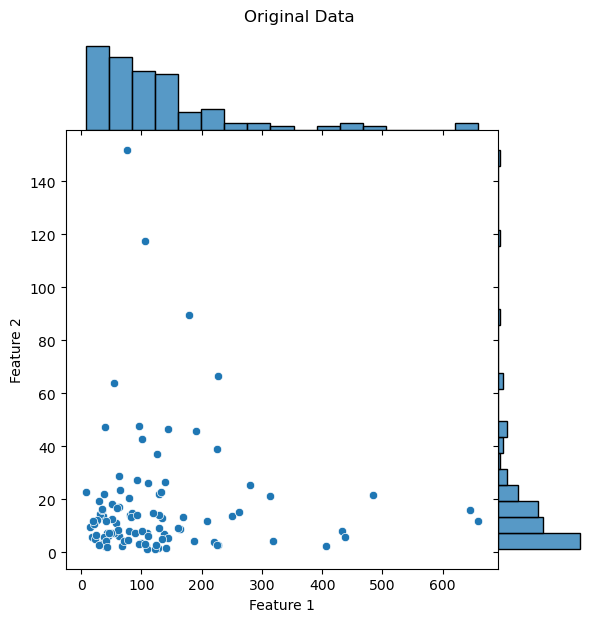

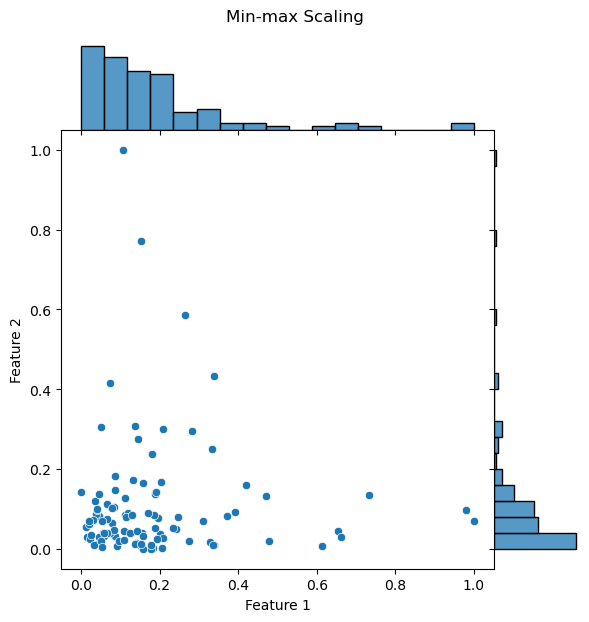

In [17]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (100 points)
np.random.seed(42)
data = np.random.lognormal(mean=0, sigma=1, size=(100, 2)) * [[100, 10]]  # Feature 1 in [0, 10000], Feature 2 in [0, 100]

def plot_with_histograms(df, title):
    g = sns.JointGrid(data=df, x='Feature 1', y='Feature 2', space=0)
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(title, y=1.03)
    plt.show()

# Apply Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create DataFrames to store the original and scaled data
df_original = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])
df_scaled = pd.DataFrame(scaled_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_original, 'Original Data')
plot_with_histograms(df_scaled, 'Min-max Scaling')



### Variance Scaling (Standardization)

Variance scaling (or standardization) transforms features so that they have a mean of 0 and a standard deviation of 1. If the original feature has a Gaussian distribution, the scaled feature does too.

$$
\tilde x  = \frac{x - \bar x}{\hat \sigma_x}
$$

This is useful for models like linear regression, logistic regression, and neural networks, where features are assumed to be normally distributed.


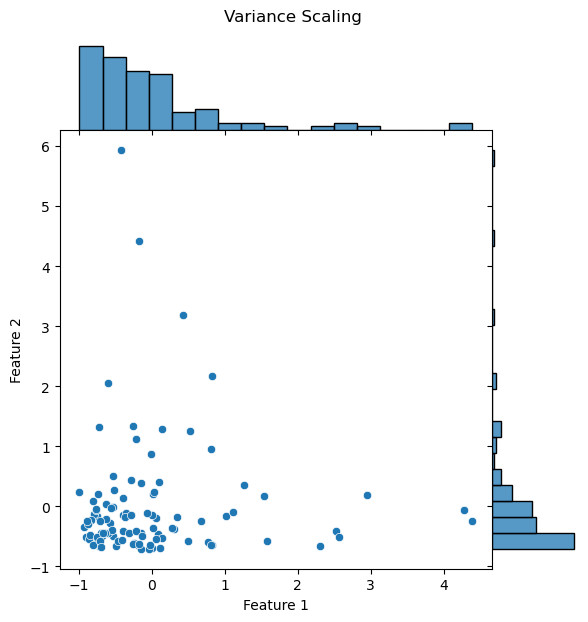

In [18]:
from sklearn.preprocessing import StandardScaler

# Apply Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Create DataFrames to store the standardized data
df_standardized = pd.DataFrame(standardized_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_standardized, 'Variance Scaling')

```{warning}
DON’T “CENTER” SPARSE DATA!

Use caution when performing min-max scaling and standardization on sparse features. Both subtract a quantity from the original feature value. 
If the shift is not zero, then these two transforms can turn a sparse feature vector where most values are zero into a dense one. This in turn could create a huge computational burden for the classifier, depending on how it is implemented.
```


### L2 Normalization

L2 normalization divides each feature vector by its $L_2$ norm, also known as the Euclidean norm, so that the resulting vectors all have a length of 1. 
This measures the length of the vector in coordinate space and it’s defined as follows:

$$
\tilde x = \frac{x}{||x||_2}
$$

where

$$
||x||_2 =  \sqrt{x^2_1 + x^2_2 + \dots + x^2_m}
$$

This is particularly useful in models like SVM or KNN, where the direction of vectors is more important than their magnitude.
L2 normalization preserves the relative distances between points and ensures that no individual feature dominates due to its scale.


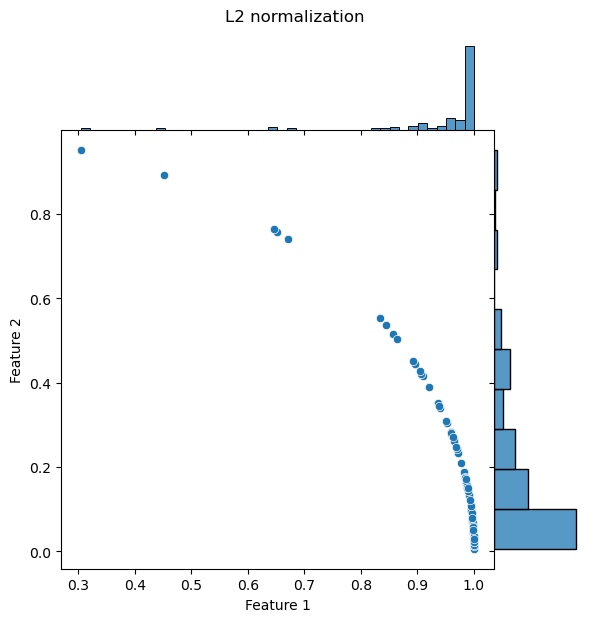

In [19]:
from sklearn.preprocessing import Normalizer

# Apply L2 Normalization
normalizer = Normalizer(norm='l2')
normalized_data = normalizer.fit_transform(data)

# Create DataFrames to store the standardized data
df_normalized = pd.DataFrame(normalized_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_normalized, 'L2 normalization')

## Feature Selection

Feature selection techniques prune away nonuseful features in order to reduce the complexity of the resulting model. 
>Given a set of $d$ features, select a subset of size $m$ that leads to the smallest classification error.


The end goal is a parsimonious model that is quicker to compute, with little or no degradation in predictive accuracy. In order to arrive at such a model, some feature selection techniques require training more than one candidate model. In other words, feature selection is not about reducing training time—in fact, some techniques increase overall training time—but about reducing model scoring time.


Once $m$ has been decided (rule of thumb $N_{class}/m>10$) choose the $m$ most informative features keeping:
- Large distances between classes
- Small distances within class


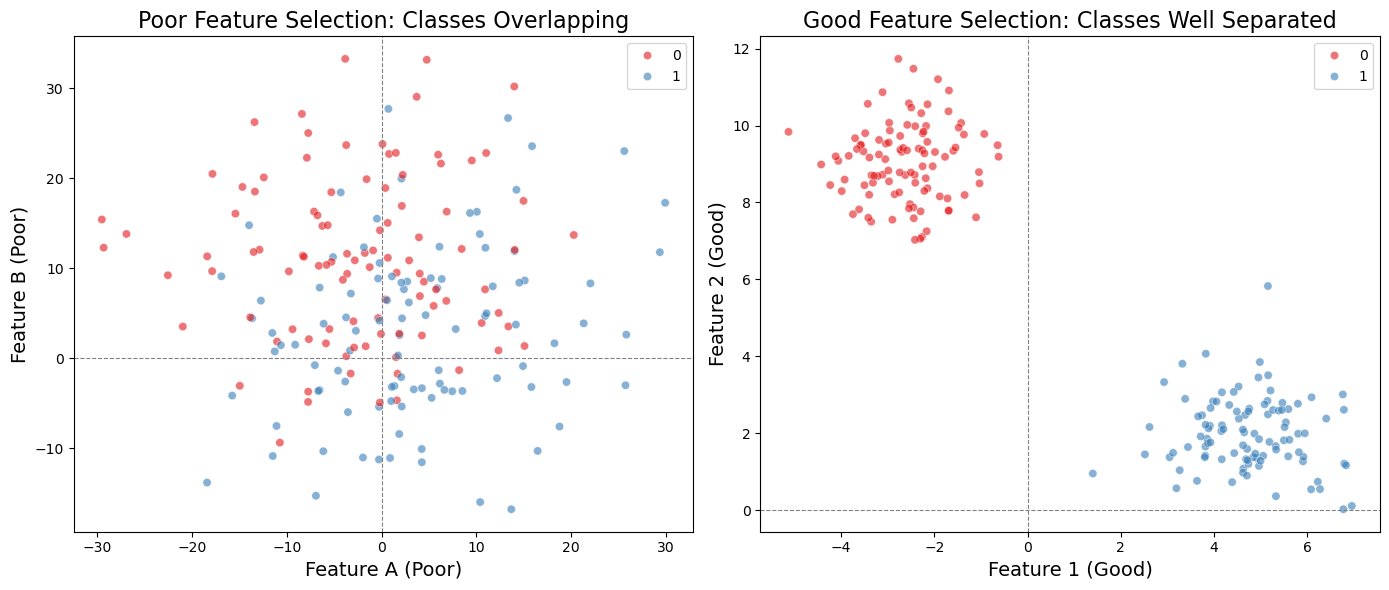

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic data with two classes
n_samples = 200
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.0)  # Reduced std for better separation

# Poor feature selection case: mixing the features
# Adding a noise feature that doesn't help in classification
X_poor = np.column_stack((X[:, 0] + np.random.normal(0, 10, n_samples), 
                           X[:, 1] + np.random.normal(0, 10, n_samples)))

# Good feature selection case: using the original features
X_good = X

# Plotting
plt.figure(figsize=(14, 6))

# Poor Feature Selection
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_poor[:, 0], y=X_poor[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('Poor Feature Selection: Classes Overlapping', fontsize=16)
plt.xlabel('Feature A (Poor)', fontsize=14)
plt.ylabel('Feature B (Poor)', fontsize=14)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')

# Good Feature Selection
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_good[:, 0], y=X_good[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('Good Feature Selection: Classes Well Separated', fontsize=16)
plt.xlabel('Feature 1 (Good)', fontsize=14)
plt.ylabel('Feature 2 (Good)', fontsize=14)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')

plt.tight_layout()
plt.show()


Feature selection techniques can be broadly categorized into four main classes:

### Filtering

Filtering methods assess the relevance of features based on their intrinsic properties, independent of any specific model. These techniques typically use statistical measures to evaluate the relationship between each feature and the target variable. Common filtering methods include:

- **Correlation Coefficients**: Evaluating the correlation between each feature and the target variable. Features with low correlation may be discarded.
- **Chi-Squared Test**: Assessing the independence between categorical features and the target, helping to select features that have the strongest association with the output.
- **Information Gain**: Measuring the reduction in uncertainty about the target variable given the feature. Higher information gain indicates a more informative feature.

Filtering methods are often fast and efficient, making them suitable for high-dimensional datasets. However, they may miss interactions between features that could be important for prediction.

### Unsupervised Methods

Unsupervised feature selection techniques do not rely on labeled data. Instead, they focus on finding patterns or structures within the data itself. Common unsupervised methods include:

- **Principal Component Analysis (PCA)**: A dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called principal components, which capture the maximum variance in the data. This allows for the selection of the most informative components.
- **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: Primarily used for visualization, t-SNE can help identify clusters in high-dimensional data, guiding the selection of features that contribute most to the separation of these clusters.

Unsupervised methods are valuable when labeled data is scarce but may not directly correspond to the target variable.

### Wrapper Methods

Wrapper methods evaluate feature subsets by training and testing a model on them, using the model's performance to determine the best features. This class of methods includes:

- **Forward Selection**: Starting with no features, it adds one feature at a time that improves model performance until no further improvement is observed.
- **Backward Elimination**: Beginning with all features, it removes one feature at a time that least impacts model performance until no improvement can be achieved.
- **Recursive Feature Elimination (RFE)**: This method iteratively removes the least important features based on model coefficients or feature importance scores until a specified number of features is retained.

While wrapper methods often provide better feature subsets tailored to a specific model, they are computationally expensive, especially with large datasets.

### Embedded Methods

Embedded methods integrate feature selection into the model training process. These techniques are often more efficient than wrapper methods and can include:

- **Lasso Regression**: A linear regression technique that adds an L1 regularization penalty, effectively shrinking some coefficients to zero and thus selecting features that contribute most to the prediction.
- **Tree-Based Methods**: Algorithms like Random Forest and Gradient Boosting provide feature importance scores based on how often a feature is used in splits across all trees, allowing for natural selection of the most significant features.

Embedded methods strike a balance between filter and wrapper methods, often yielding high-quality feature subsets with lower computational costs.


## Code Example: The Mobile Price dataset 
 1. The data is already tidy and partitioned into training and testing csv files. 
 2. There are 2000 observations in the training set and 1000 in testing.
 3. Each observation consisits of 20 phone features (columns) and one categorical label (final column) describing the phone's price range.

### Data description
| Feature | Description |
| ------- | ----------- |
| battery_power | Total energy a battery can store in one time measured in mAh |
|blue | Has Bluetooth or not |
|clock_speed | the speed at which microprocessor executes instructions |
|dual_sim | Has dual sim support or not |
| fc | Front Camera megapixels |
| four_g | Has 4G or not |
| int_memory | Internal Memory in Gigabytes |
| m_dep | Mobile Depth in cm |
| mobile_wt | Weight of mobile phone |
| n_cores | Number of cores of the processor |
| pc | Primary Camera megapixels |
| px_height | Pixel Resolution Height |
| px_width | Pixel Resolution Width |
| ram | Random Access Memory in MegaBytes |
| sc_h | Screen Height of mobile in cm |
| sc_w | Screen Width of mobile in cm |
| talk_time | the longest time that a single battery charge will last when you are |
| three_g | Has 3G or not |
| touch_screen | Has touch screen or not |
| wifi | Has wifi or not |
| price_range | This is the target variable with a value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost). |

## Setup
Let's get all the requirements sorted before we move on to the excercise. Don't worry too much about the models we'll be using or how to train them for now. 

In [1]:
# Globals
seed = 1017

#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tableone import TableOne
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

#magic
%matplotlib inline

## What question am I answering?
Well, we want to demonstrate the utility of feature selection. To this end, we compare predictive power in a model with and without feature selection. So, for every parsimonious model we train let's compare its performance with that of its couterpart prodigious model (i.e. model that uses all the features).

In [2]:
# disable warnings generated by deprecated numpy behaviour
import warnings
warnings.filterwarnings('ignore')

## Loading the data
We should have a look at how the features are distributed grouped by the labels. For this we'll generate a table 1.

In [3]:
# load the data as a pandas dataframe
df = pd.read_csv("Lesson_02_data/train.csv")
df_test = pd.read_csv("Lesson_02_data/test.csv")

# Generate table 1
TableOne(df, groupby=df.columns[-1],
         pval=True,
         dip_test=True,
         normal_test=True,
         tukey_test=True)

Grouped by price_range                                                                                         
                                          Missing          Overall               0               1               2               3 P-Value
n                                                             2000             500             500             500             500        
battery_power, mean (SD)                        0   1238.5 (439.4)  1116.9 (410.8)  1228.9 (438.6)  1228.3 (452.9)  1380.0 (415.0)  <0.001
blue, n (%)              0                      0      1010 (50.5)      257 (51.4)      255 (51.0)      257 (51.4)      241 (48.2)   0.698
                         1                              990 (49.5)      243 (48.6)      245 (49.0)      243 (48.6)      259 (51.8)        
clock_speed, mean (SD)                          0        1.5 (0.8)       1.6 (0.8)       1.5 (0.8)       1.5 (0.8)       1.5 (0.8)   0.687
dual_sim, n (%)          0                      0       981 (49.0)      250 (50.0)      245 (49.0)      251 (50.2)      235 (47.0)   0.732
                         1                             1019 (50.9)      250 (50.0)      255 (51.0)      249 (49.8)      265 (53.0)        
fc, mean (SD)                                   0        4.3 (4.3)       4.1 (4.2)       4.3 (4.5)       4.5 (4.3)       4.3 (4.3)   0.510
four_g, n (%)            0                      0       957 (47.9)      241 (48.2)      238 (47.6)      253 (50.6)      225 (45.0)   0.365
                         1                             1043 (52.1)      259 (51.8)      262 (52.4)      247 (49.4)      275 (55.0)        
int_memory, mean (SD)                           0      32.0 (18.1)     31.2 (18.1)     32.1 (18.0)     30.9 (18.4)     34.0 (17.9)   0.033
m_dep, mean (SD)                                0        0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)   0.212
mobile_wt, mean (SD)                            0     140.2 (35.4)    140.6 (36.4)    140.5 (35.7)    143.6 (34.3)    136.3 (34.9)   0.013
n_cores, n (%)           1                      0       242 (12.1)        49 (9.8)       76 (15.2)       52 (10.4)       65 (13.0)   0.488
                         2                              247 (12.3)       69 (13.8)       59 (11.8)       57 (11.4)       62 (12.4)        
                         3                              246 (12.3)       62 (12.4)       69 (13.8)       56 (11.2)       59 (11.8)        
                         4                              274 (13.7)       67 (13.4)       76 (15.2)       73 (14.6)       58 (11.6)        
                         5                              246 (12.3)       59 (11.8)       51 (10.2)       66 (13.2)       70 (14.0)        
                         6                              230 (11.5)       61 (12.2)       54 (10.8)       57 (11.4)       58 (11.6)        
                         7                              259 (13.0)       66 (13.2)       55 (11.0)       69 (13.8)       69 (13.8)        
                         8                              256 (12.8)       67 (13.4)       60 (12.0)       70 (14.0)       59 (11.8)        
pc, mean (SD)                                   0        9.9 (6.1)       9.6 (6.1)       9.9 (6.1)      10.0 (6.0)      10.2 (6.1)   0.480
px_height, mean (SD)                            0    645.1 (443.8)   536.4 (372.8)   666.9 (441.4)   632.3 (445.8)   744.8 (483.7)  <0.001
px_width, mean (SD)                             0   1251.5 (432.2)  1150.3 (413.0)  1251.9 (433.6)  1234.0 (427.8)  1369.8 (426.8)  <0.001
ram, mean (SD)                                  0  2124.2 (1084.7)   785.3 (362.8)  1679.5 (465.9)  2582.8 (496.2)  3449.2 (393.0)  <0.001
sc_h, mean (SD)                                 0       12.3 (4.2)      12.3 (4.2)      12.2 (4.2)      12.0 (4.2)      12.7 (4.2)   0.083
sc_w, mean (SD)                                 0        5.8 (4.4)       5.7 (4.2)       5.5 (4.2)       5.7 (4.3)       6.1 (4.7)   0.

## Comparing Models
Let's define a function that will calculate the prodigious and parsimonious model performance.

In [4]:
#define function that compares selected features to full model
def compare_models(dataset, selfeat):
    """compare parsimonious and full linear model"""
    
    # get predictors and labels
    X = dataset.drop('price_range',axis=1)  #independent columns
    y = dataset['price_range']    #target column i.e price range

    #get selected feature indecies
    isel = [X.columns.get_loc(feat) for feat in selfeat if feat in X]
    
    #70-30 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
 

    #define the prodigious and parsimonious logistic models
    prodmodel = LinearRegression()
    parsmodel = LinearRegression()

    #Fit the models
    prodmodel.fit(X_train, y_train)
    parsmodel.fit(X_train[selfeat], y_train) 

    #Report errors
    display('Prodigious Model Score: %.2f' %prodmodel.score(X_test, y_test))
    display('Parsimonious Model Score: %.2f' %parsmodel.score(X_test[selfeat], y_test))

    return

## Filtering 

Filtering techniques preprocess features to remove ones that are unlikely to be useful for the model. For example, one could compute the correlation or mutual information between each feature and the response variable, and filter out the features that fall below a threshold. Filtering techniques are much cheaper than the wrapper techniques described next, but they do not take into account the model being employed. Hence, they may not be able to select the right features for the model. It is best to do prefiltering conservatively, so as not to inadvertently eliminate useful features before they even make it to the model training step.

>The Table 1 conveniently has calculated the association of each feature with the outcome. Let's select only those features that are significatly (p<.05) associated. 

In [5]:
selfeat = ['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram', 'sc_h']
compare_models(df, selfeat)

'Prodigious Model Score: 0.91'

'Parsimonious Model Score: 0.92'

>By keeping only 7 features the parsimonious model has the same score as the full model that uses all 20 features. 

## Unsupervised Methods
**Remove highly correlated features**: to remove the correlated features, we can make use of the corr() method of the pandas dataframe. 

>The **corr() method** returns a correlation matrix containing correlation between all the columns of the dataframe. A useful way to visualize the correlations is with a heatmap. We'll use the seaborn library for this.

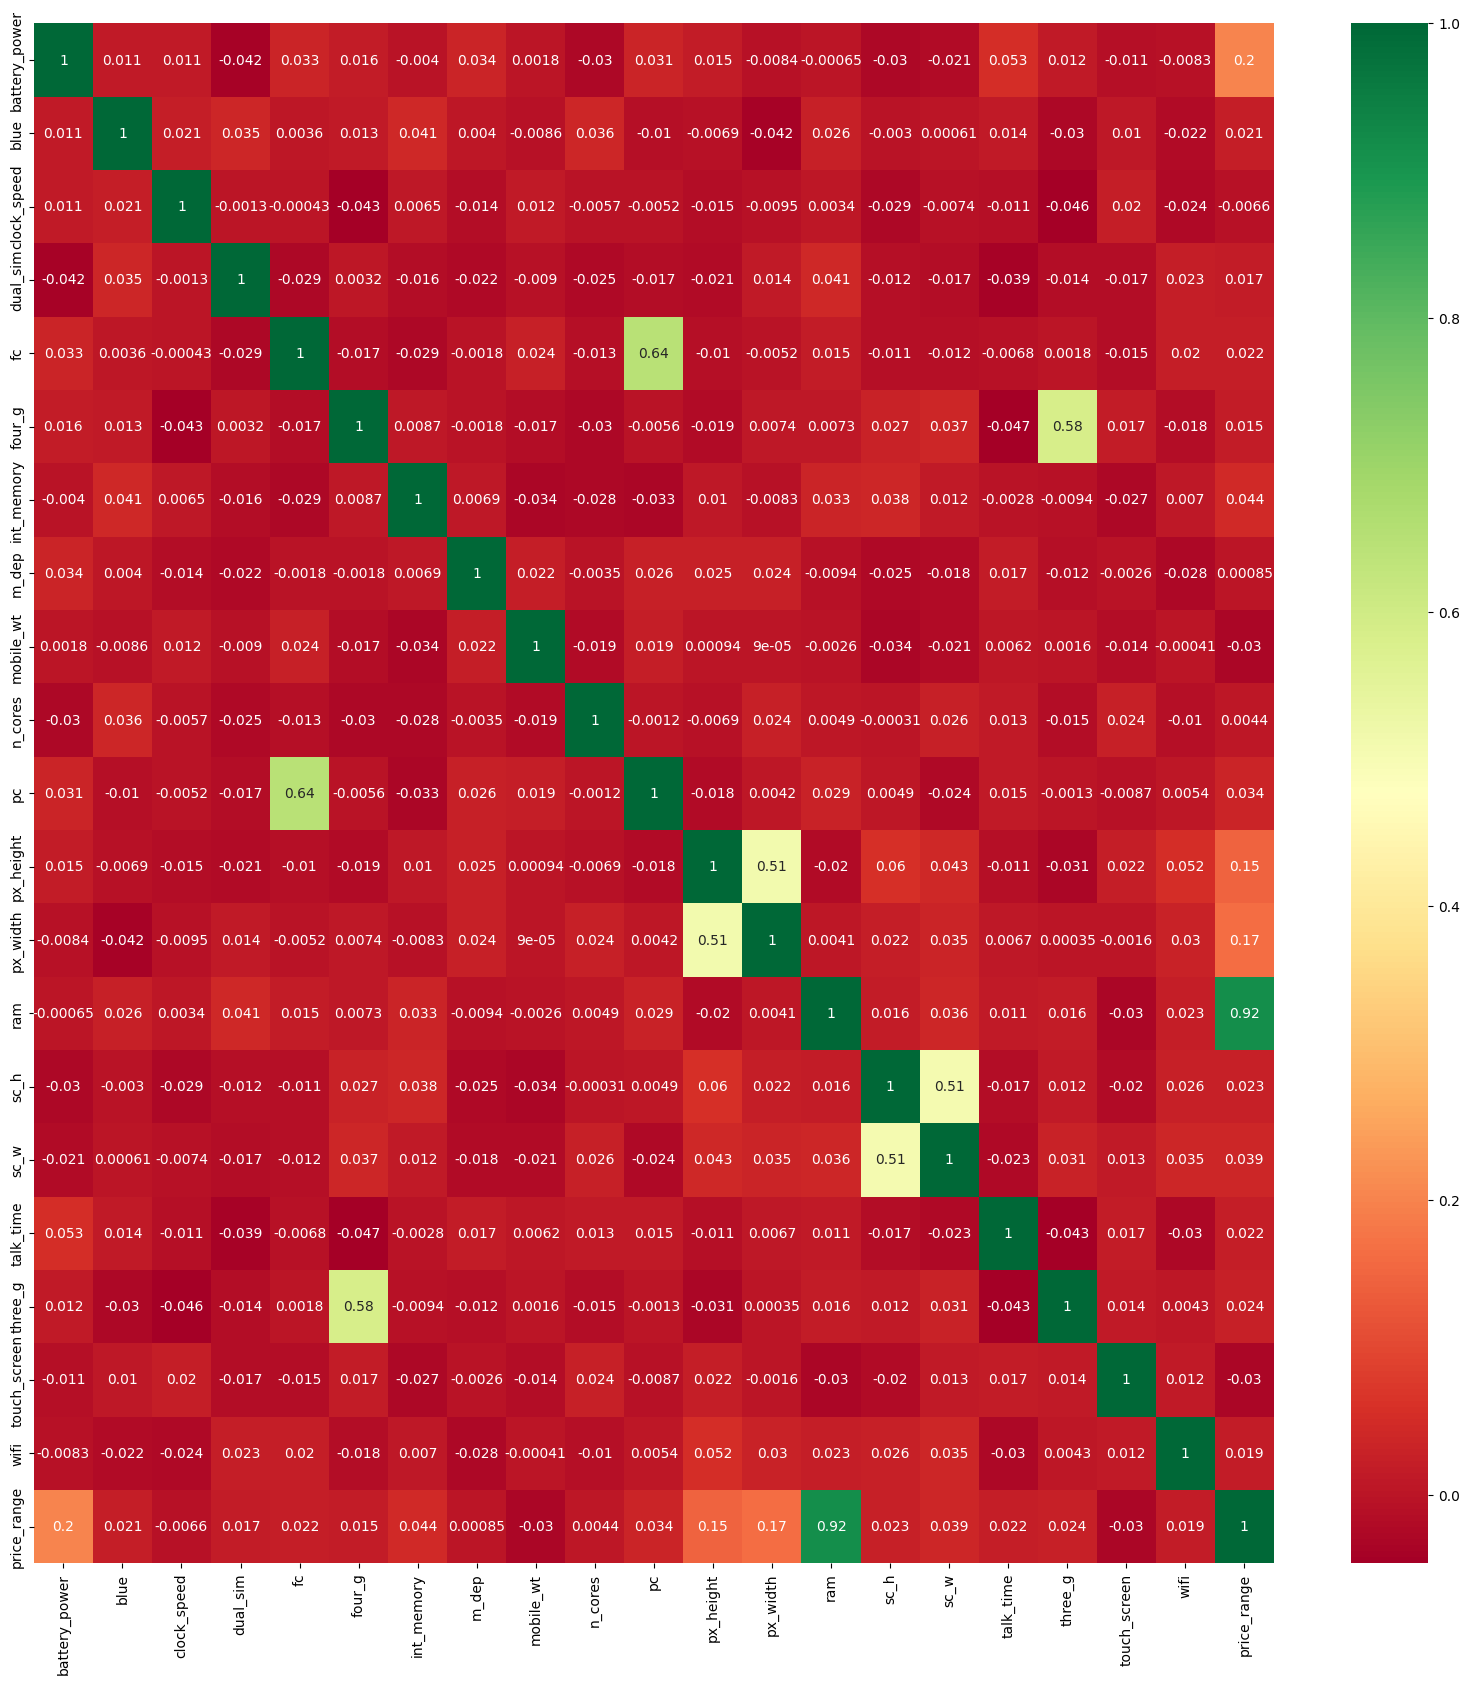

In [6]:
#Create a correlation matrix for the columns in the dataset
correlation_matrix = df.corr()

#plot heat map
plt.figure(figsize=(20,20))
g=sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")

We can loop through all the columns in the correlation_matrix and keep track of the features with a correlation value > 0.5. This 0.5 cut-off is quite strict and chosen for demonstration purposes. A more reasonable value is 80-90%. 

In [7]:
#init an empty set that will contain the names of the correlated features
correlated_features = set()

#loop over lower triangle of pairs of features
#     do not consider the last feature which is the label 
for i in range(len(correlation_matrix .columns) - 1):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            #accumulate the names of the second correlated feature
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

In [8]:
#display the correlated features
display(correlated_features)

{'fc', 'four_g', 'px_height', 'sc_h'}

These features are correlated to at least one other feature and can be considered redundant. Let's not include them in our parsimonious set and see how it effects model performance.

In [9]:
#add label to the correlated features which we will drop
correlated_features.add('price_range')
selfeat = df.columns.drop(correlated_features)
compare_models(df, selfeat)

'Prodigious Model Score: 0.91'

'Parsimonious Model Score: 0.90'

>In this case the parsimonious model scores (goodness of fit) lower than the full model.

## Wrapper methods 

These techniques are expensive, but they allow you to try out subsets of features, which means you won’t accidentally prune away features that are uninformative by themselves but useful when taken in combination. The wrapper method treats the model as a black box that provides a quality score of a proposed subset for features. There is a separate method that iteratively refines the subset.

>**Recursive feature elimination (RFE)** is a stepwise feature selection process implemented in sklearn. Recall, the model used for feature selection does not have to be the same as the predictive model. Here we will use a tree based model for RFE.

In [10]:
# get predictors and labels
X = df.drop('price_range', axis=1)  
y = df['price_range']

# use tree based model for RFE
rfe = RFECV(estimator=DecisionTreeClassifier())

# fit RFE
rfe.fit(X, y)

# summarize all features
for i in range(X.shape[1]):
    display('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

'Column: 0, Selected True, Rank: 1.000'

'Column: 1, Selected False, Rank: 14.000'

'Column: 2, Selected False, Rank: 7.000'

'Column: 3, Selected False, Rank: 11.000'

'Column: 4, Selected False, Rank: 12.000'

'Column: 5, Selected False, Rank: 15.000'

'Column: 6, Selected False, Rank: 3.000'

'Column: 7, Selected False, Rank: 10.000'

'Column: 8, Selected False, Rank: 2.000'

'Column: 9, Selected False, Rank: 5.000'

'Column: 10, Selected False, Rank: 9.000'

'Column: 11, Selected True, Rank: 1.000'

'Column: 12, Selected True, Rank: 1.000'

'Column: 13, Selected True, Rank: 1.000'

'Column: 14, Selected False, Rank: 6.000'

'Column: 15, Selected False, Rank: 4.000'

'Column: 16, Selected False, Rank: 8.000'

'Column: 17, Selected False, Rank: 13.000'

'Column: 18, Selected False, Rank: 16.000'

'Column: 19, Selected False, Rank: 17.000'

We can see which features were selected by their column index. They correspond to features 'battery_power', 'px_height', 'px_width', and 'ram' . Let's compare the parsimonious linear model with the full model.

In [11]:
#get the column indecies
selcol = [0, 11, 12, 13]
#get the column names
selfeat = df.columns[selcol]
#compare models
compare_models(df, selfeat)

'Prodigious Model Score: 0.91'

'Parsimonious Model Score: 0.91'


## Embedded methods

These methods perform feature selection as part of the model training process. For example, a decision tree inherently performs feature selection because it selects one feature on which to split the tree at each training step. Another example is the $L_1$ regularizer, which can be added to the training objective of any linear model. 
The $L_1$ regularizer encourages models that use a few features as opposed to a lot of features, so it’s also known as a sparsity constraint on the model. Embedded methods incorporate feature selection as part of the model training process. They are not as powerful as wrapper methods, but they are nowhere near as expensive. Compared to filtering, embedded methods select features that are specific to the model. In this sense, embedded methods strike a balance between computational expense and quality of results.



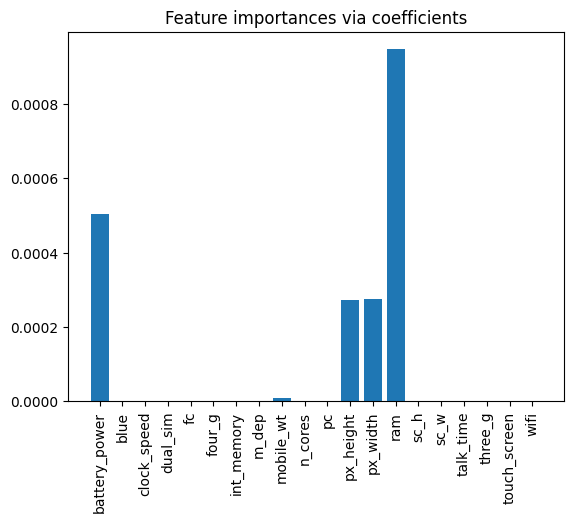

In [12]:
from sklearn.linear_model import LassoCV

# get predictors and labels
X = np.array(df.drop('price_range', axis=1)) 
y = np.array(df['price_range'])

#train lasso (least absolute shrinkage and selection operator) model with 5-fold cross validataion
lasso = LassoCV(cv=5, random_state=0).fit(X, y)

#display the model score
lasso.score(X, y)

#plot feature importance based on coeficients
importance = np.abs(lasso.coef_)
feature_names = np.array(df.columns.drop('price_range'))
plt.bar(height=importance, x=feature_names)
plt.xticks(rotation=90)
plt.title("Feature importances via coefficients")
plt.show()

>Again we see battery power, px_height, px_width, and ram are the most important features that influence price.